## Hidden Markov Models

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

Hidden Markov models (HMMs) are a probability distribution over sequences that are made up of two components: a set of probability distributions and a transition matrix (sometimes represented as a graph) describing how sequences can proceed through the model. HMMs are the flagship implementation in pomegranate and were the first algorithm originally implemented.

HMMs are a form of structured prediction method that are popular for tagging all elements in a sequence with some "hidden" state. They can be thought of as extensions of Markov chains where, instead of the probability of the next observation being dependant on the current observation, the probability of the next hidden state is dependant on the current hidden state, and the next observation is derived from that hidden state. An example of this can be part of speech tagging, where the observations are words and the hidden states are parts of speech. Each word gets tagged with a part of speech, but dynamic programming is utilized to search through all potential word-tag combinations to identify the best set of tags across the entire sentence.

In [1]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')

import torch

numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,torch,pomegranate

Populating the interactive namespace from numpy and matplotlib
numpy      : 1.23.4
scipy      : 1.9.3
torch      : 1.13.0
pomegranate: 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.15.0-208-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



### Identification of GC-rich regions of the genome

Lets take the simplified example of CG island detection on a sequence of DNA. DNA is made up of the four canonical nucleotides, abbreviated 'A', 'C', 'G', and 'T'. We can say that regions of the genome that are enriched for nucleotides 'C' and 'G' are 'CG islands', which is a simplification of the real biological concept but sufficient for our example. The issue with identifying these regions is that they are not exclusively made up of the nucleotides 'C' and 'G', but have some 'A's and 'T's scatted amongst them. A simple model that looked for long stretches of C's and G's would not perform well, because it would miss most of the real regions.

We can start off by building the model. Because HMMs involve the transition matrix, which is often represented using a graph over the hidden states, building them requires a few more steps that a simple distribution or the mixture model. Our simple model will be composed of two distributions. One distribution wil be a uniform distribution across all four characters and one will have a preference for the nucleotides C and G, while still allowing the nucleotides A and T to be present.

In [2]:
from pomegranate.distributions import Categorical

d1 = Categorical([[0.25, 0.25, 0.25, 0.25]])
d2 = Categorical([[0.10, 0.40, 0.40, 0.10]])

Now we can define the HMM and pass in states. Note that in pomegranate v1.0.0, HMMs are split into two implementations: `DenseHMM`, which has a dense transition matrix and so can use standard matrix multiplies in the backend, and `SparseHMM`, which has a sparse transition matrix and uses more complicated scatter-add operations. Also note that you no longer need to wrap the distributions in `Node` objects. You pass the distributions in directly.

In [3]:
from pomegranate.hmm import DenseHMM

model = DenseHMM()
model.add_distributions([d1, d2])

Then we have to define the transition matrix, which is the probability of going from one hidden state to the next hidden state. In some cases, like this one, there are high self-loop probabilities, indicating that it's likely that one will stay in the same hidden state from one observation to the next in the sequence. Other cases have a lower probability of staying in the same state, like the part of speech tagger. A part of the transition matrix is the start probabilities, which is the probability of starting in each of the hidden states. Because we create these transitions one at a time, they are very amenable to sparse transition matrices, where it is impossible to transition from one hidden state to the next. Note that we are passing in distribution objects, not node objects as in the previous version, here.

In [4]:
model.add_edge(model.start, d1, 0.5)
model.add_edge(model.start, d2, 0.5)
model.add_edge(d1, d1, 0.9)
model.add_edge(d1, d2, 0.1)
model.add_edge(d2, d1, 0.1)
model.add_edge(d2, d2, 0.9)

Another big change is that we no longer need to bake the HMM once we're done!

In [5]:
#model.bake()

Now we can create a sequence to run through the model. Make sure that this sequence has been converted to a numeric representation of categories. This can be done either simply, as below, or using a preprocessing tool from some other package like scikit-learn. Also, make sure that your input sequence is 3D with the three dimensions corresponding to (batch_size, sequence length, dimensionality). Here, batch_size and dimensionality are both 1. The inclusion of batch size helps significantly when processing several sequences in parallel.

In [6]:
sequence = 'CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC'
X = numpy.array([[[['A', 'C', 'G', 'T'].index(char)] for char in sequence]])
X.shape

(1, 51, 1)

Now we can make predictions on some sequence. Let's create some sequence that has a CG enriched region in the middle and see whether we can identify it.

In [7]:
y_hat = model.predict(X)

print("sequence: {}".format(''.join(sequence)))
print("hmm pred: {}".format(''.join([str(y.item()) for y in y_hat[0]])))

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
hmm pred: 000000000000000111111111111111100000000000000001111


It looks like it successfully identified a CG island in the middle (the long stretch of 1's) and another shorter one at the end. More importantly, the model wasn't tricked into thinking that every CG or even pair of CGs was an island. It required many C's and G's to be part of a longer stretch to identify that region as an island. Naturally, the balance of the transition and emission probabilities will heavily influence what regions are detected.

Let's say, though, that we want to get rid of that CG island prediction at the end because we don't believe that real islands can occur at the end of the sequence. We can take care of this by adding in an explicit end state that only the non-island hidden state can get to. We enforce that the model has to end in the end state, and if only the non-island state gets there, the sequence of hidden states must end in the non-island state. Here's how:

In [8]:
model = DenseHMM()
model.add_distributions([d1, d2])
model.add_edge(model.start, d1, 0.5)
model.add_edge(model.start, d2, 0.5)
model.add_edge(d1, d1, 0.89 )
model.add_edge(d1, d2, 0.10 )
model.add_edge(d1, model.end, 0.01)
model.add_edge(d2, d1, 0.1 )
model.add_edge(d2, d2, 0.9)

Note that all we did was add a transition from n1 to model.end with some low probability. This probability doesn't have to be high if there's only a single transition there, because there's no other possible way of getting to the end state.

In [9]:
y_hat = model.predict(X)

print("sequence: {}".format(''.join(sequence)))
print("hmm pred: {}".format(''.join([str(y.item()) for y in y_hat[0]])))

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
hmm pred: 000000000000000111111111111111100000000000000000000


This seems far more reasonable. There is a single CG island surrounded by background sequence, and something at the end. If we knew that CG islands cannot occur at the end of sequences, we need only modify the underlying structure of the HMM in order to say that the sequence must end from the background state.

In the same way that mixtures could provide probabilistic estimates of class assignments rather than only hard labels, hidden Markov models can do the same. These estimates are the posterior probabilities of belonging to each of the hidden states given the observation, but also given the rest of the sequence.

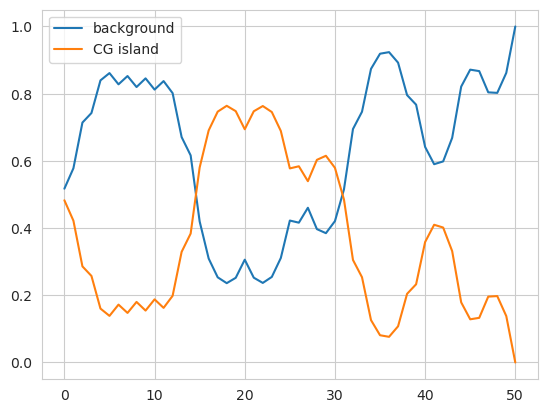

In [10]:
plt.plot(model.predict_proba(X)[0], label=['background', 'CG island'])
plt.legend()
plt.show()

We can see here the transition from the first non-island region to the middle island region, with high probabilities in one column turning into high probabilities in the other column. The predict method is just taking the most likely element --- the maximum-a-posteriori estimate.

In addition to using the forward-backward algorithm to just calculate posterior probabilities for each observation, we can count the number of transitions that are predicted to occur across each edge.

In [11]:
transitions = model.forward_backward(X)[0][0]
transitions

tensor([[28.9100,  2.4128],
        [ 2.8955, 15.7806]])

### Initializing Hidden Markov Models

There are two ways to initialize an HMM using pomegranate. The first is to explicitly pass a list of distributions, a dense transition matrix, and optionally start and end probabilities. We can recreate the above model using this approach.

In [12]:
model = DenseHMM([d1, d2], edges=[[0.89, 0.1], [0.1, 0.9]], starts=[0.5, 0.5], ends=[0.01, 0.0])

We can check that this initialization produces the same model by making the same plot of predicted probabilities across the sequence.

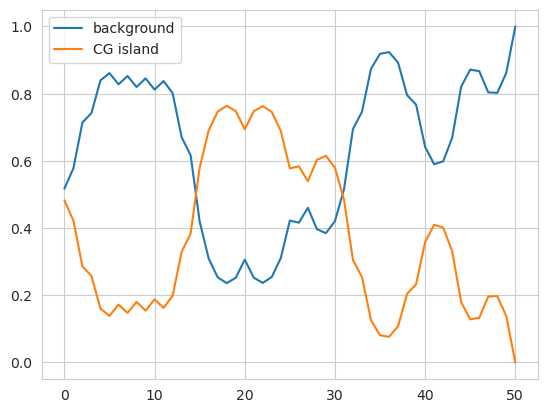

In [13]:
plt.plot(model.predict_proba(X)[0], label=['background', 'CG island'])
plt.legend()
plt.show()

This also works when creating a `SparseHMM` object, though the edges must be a list of 3-ples rather than a matrix.

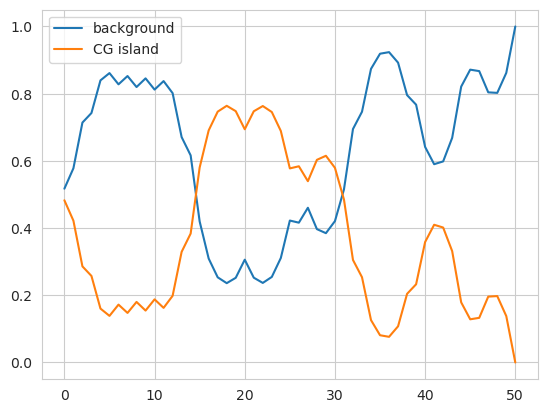

In [14]:
from pomegranate.hmm import SparseHMM

edges = [
    [d1, d1, 0.89],
    [d1, d2, 0.1],
    [d2, d1, 0.1],
    [d2, d2, 0.9]
]

model = SparseHMM([d1, d2], edges=edges, starts=[0.5, 0.5], ends=[0.01, 0.0])

plt.plot(model.predict_proba(X)[0], label=['background', 'CG island'])
plt.legend()
plt.show()

The second way is to follow the procedure outlined above where you first create an uninitialized model with nothing passed into it and then you add the distributions and edges using the appropriate methods. Although this can be used for both `DenseHMM` and `SparseHMM` modls, this is likely most useful for `SparseHMM` models that are very sparse or when you're trying to procedurally generate an HMM based on external factors. Here is the same code as before that implements the HMM using this approach.

In [15]:
model = SparseHMM()
model.add_distributions([d1, d2])
model.add_edge(model.start, d1, 0.5)
model.add_edge(model.start, d2, 0.5)
model.add_edge(d1, d1, 0.89 )
model.add_edge(d1, d2, 0.10 )
model.add_edge(d1, model.end, 0.01)
model.add_edge(d2, d1, 0.1 )
model.add_edge(d2, d2, 0.9)

Similar to other methods, we can create an HMM with uninitialized distributions. These distributions will be initialized using k-means clustering when provided with data. When using a `DenseHMM` we can also choose to not pass in edges and have them be initialized to uniform probabilities. When using a `SparseHMM` we must pass in edges because, otherwise, the model will not know which edges exist and which do not. Essentially, it would have to assume uniform probabilities as well, at which point the model would have a dense transition matrix but just operate inefficiently by treating it as a sparse matrix.

In [16]:
from pomegranate.distributions import Normal

X3 = torch.randn(100, 50, 2)

model3 = DenseHMM([Normal(), Normal(), Normal()], verbose=True)
model3._initialize(X3)
model3.distributions[0].means, model3.distributions[1].means, model3.distributions[2].means

(Parameter containing:
 tensor([-0.6929,  0.2710]),
 Parameter containing:
 tensor([1.0994, 0.7262]),
 Parameter containing:
 tensor([ 0.4207, -1.0267]))

You can control how the k-means itself is initialized by passing in a value to `init`.

However, you do not need to manually initialize your models. If you call the `fit` method or the `summarize` method, these distributions will be initialized if they have not yet been.

In [17]:
X3 = torch.randn(100, 50, 2)

model3 = DenseHMM([Normal(), Normal(), Normal()], max_iter=5, verbose=True)
model3.fit(X3)

[1] Improvement: -23.134765625, Time: 0.007689s


DenseHMM(
  (start): Silent()
  (end): Silent()
  (distributions): ModuleList(
    (0): Normal()
    (1): Normal()
    (2): Normal()
  )
)

#### Dense and Sparse HMMs

Separately from whether the HMM is initialized by passing in the distributions and edges initially or building the model programmatically, the transition matrix can be represented using a sparse matrix or a dense matrix. Although a dense transition matrix allows fast matrix multiplications to be used for each algorithm, once there are enough zeroes a matrix multiply wastes a lot of computation handling them. 

Because the backend and strategy for initializing the model (i.e., passing in a dense transition matrix or a list of edges) differ, pomegranate v1.0.0 splits the implementation in two: `DenseHMM` and `SparseHMM`. Both have the same functionality and API and, given the same transition matrix, will yield the same result. 

In [18]:
edges = [[0.89, 0.1], [0.1, 0.9]]
starts = [0.5, 0.5]
ends = [0.01, 0.0]

model1 = DenseHMM([d1, d2], edges=edges, starts=starts, ends=ends)
model1.predict_proba(X)[0][12:19]

tensor([[0.8016, 0.1984],
        [0.6708, 0.3292],
        [0.6163, 0.3837],
        [0.4196, 0.5804],
        [0.3092, 0.6908],
        [0.2535, 0.7465],
        [0.2361, 0.7639]])

In [19]:
edges = [
    [d1, d1, 0.89],
    [d1, d2, 0.1],
    [d2, d1, 0.1],
    [d2, d2, 0.9]
]

model2 = SparseHMM([d1, d2], edges=edges, starts=starts, ends=ends)
model2.predict_proba(X)[0][12:19]

tensor([[0.8016, 0.1984],
        [0.6708, 0.3292],
        [0.6163, 0.3837],
        [0.4196, 0.5804],
        [0.3092, 0.6908],
        [0.2535, 0.7465],
        [0.2361, 0.7639]])

In [20]:
X = numpy.random.choice(4, size=(1000, 500, 1))

%timeit -n 10 -r 5 model1.predict_proba(X)
%timeit -n 10 -r 5 model2.predict_proba(X)

102 ms ± 13.9 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
177 ms ± 12.9 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


Check out the benchmarks folder to see a more thorough comparison of the two, but it looks like even for a tiny model that the dense transition matrix is around twice as fast.

### Fitting Hidden Markov Models

Hidden Markov models are usually fit to unlabeled data using the Baum-Welch algorithm. This is a structured EM algorithm that accounts for transitions between distributions as well as the distribution parameters themselves. Essentially, one uses the forward-backward algorithm to infer the expected number of transitions across each edge and the expected probability of each observation aligning to each state and uses those estimates to update the underlying parameters.

In [21]:
d1 = Categorical([[0.25, 0.25, 0.25, 0.25]])
d2 = Categorical([[0.10, 0.40, 0.40, 0.10]])

edges = [[0.89, 0.1], [0.1, 0.9]]
starts = [0.5, 0.5]
ends = [0.01, 0.0]

model = DenseHMM([d1, d2], edges=edges, starts=starts, ends=ends, verbose=True)
model.fit(X)

[1] Improvement: 16405.125, Time: 0.09408s
[2] Improvement: 420.75, Time: 0.0876s
[3] Improvement: 207.25, Time: 0.09545s
[4] Improvement: 116.125, Time: 0.107s
[5] Improvement: 75.3125, Time: 0.09284s
[6] Improvement: 47.6875, Time: 0.0797s
[7] Improvement: 34.75, Time: 0.1045s
[8] Improvement: 27.3125, Time: 0.08161s
[9] Improvement: 16.0625, Time: 0.08903s
[10] Improvement: 15.6875, Time: 0.1197s
[11] Improvement: 9.1875, Time: 0.09623s
[12] Improvement: 10.625, Time: 0.08911s
[13] Improvement: 8.125, Time: 0.1064s
[14] Improvement: 6.3125, Time: 0.07936s
[15] Improvement: 2.3125, Time: 0.08887s
[16] Improvement: 5.0625, Time: 0.108s
[17] Improvement: 4.3125, Time: 0.08656s
[18] Improvement: 3.1875, Time: 0.08103s
[19] Improvement: 1.75, Time: 0.1282s
[20] Improvement: 4.4375, Time: 0.09025s
[21] Improvement: -1.6875, Time: 0.07991s


DenseHMM(
  (start): Silent()
  (end): Silent()
  (distributions): ModuleList(
    (0): Categorical()
    (1): Categorical()
  )
)

We can change the number of iterations by setting either the `max_iter` parameter or the `tol` parameter.

In [22]:
d1 = Categorical([[0.25, 0.25, 0.25, 0.25]])
d2 = Categorical([[0.10, 0.40, 0.40, 0.10]])

edges = [[0.89, 0.1], [0.1, 0.9]]
starts = [0.5, 0.5]
ends = [0.01, 0.0]

model = DenseHMM([d1, d2], edges=edges, starts=starts, ends=ends, max_iter=5, verbose=True)
model.fit(X)

[1] Improvement: 16405.125, Time: 0.1029s
[2] Improvement: 420.75, Time: 0.1356s
[3] Improvement: 207.25, Time: 0.1192s
[4] Improvement: 116.125, Time: 0.08874s
[5] Improvement: 75.3125, Time: 0.1781s


DenseHMM(
  (start): Silent()
  (end): Silent()
  (distributions): ModuleList(
    (0): Categorical()
    (1): Categorical()
  )
)

In [23]:
d1 = Categorical([[0.25, 0.25, 0.25, 0.25]])
d2 = Categorical([[0.10, 0.40, 0.40, 0.10]])

edges = [[0.89, 0.1], [0.1, 0.9]]
starts = [0.5, 0.5]
ends = [0.01, 0.0]

model = DenseHMM([d1, d2], edges=edges, starts=starts, ends=ends, tol=50, verbose=True)
model.fit(X)

[1] Improvement: 16405.125, Time: 0.1512s
[2] Improvement: 420.75, Time: 0.1788s
[3] Improvement: 207.25, Time: 0.1501s
[4] Improvement: 116.125, Time: 0.127s
[5] Improvement: 75.3125, Time: 0.08657s
[6] Improvement: 47.6875, Time: 0.1011s


DenseHMM(
  (start): Silent()
  (end): Silent()
  (distributions): ModuleList(
    (0): Categorical()
    (1): Categorical()
  )
)

The same parameters and signature applies to `SparseHMM` models.